In [244]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn import svm
from sklearn.model_selection import train_test_split
from PIL import Image
import scipy.io
import imageio
import glob
import cv2
from numpy import asarray
from scipy.spatial.distance import cdist
from scipy.optimize import fmin
import matplotlib.image as mpimg
import scipy.ndimage as ndi
from sklearn.metrics.pairwise import cosine_similarity
import numba
import pandas as pd
from PIL import Image

In [245]:
###think about standard deviation of angles, perimeter,vector size , deviation of vector sizes
### irregular surfaces might have low angles
def irregularity(image, feature):   
    if isinstance(image, str):  # Check if the input is a file path
        #img3 = cv2.imread(image, cv2.IMREAD_GRAYSCALE)  # Read the image as grayscale
        img = cv2.imread(image, cv2.IMREAD_COLOR)
        # Convert the image from BGR (OpenCV's default) to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img3 = np.array(img_rgb, dtype=np.uint8)
        #print("a")
    else:
        # Check if the input is already an image array
        img3 = np.array(image, dtype=np.uint8)

    #divide by colours
    ret, thresh = cv2.threshold(img3, 127, 255, 0)
    # Find the outermost contour
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Decimate the contour to an approximation, squeeze to get an N x 2 array
    #print(len(contours))
    
    try:
        dec_points = np.squeeze(cv2.approxPolyDP(np.squeeze(contours), 1, True)) 
        # Compute the difference between the vector and the next one in a circular way
        vecs = dec_points - np.roll(dec_points, 1, 0)
        norm_vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)
        angles = np.arccos(np.sum(norm_vecs * np.roll(norm_vecs, 1, axis=0), axis=1))
        if feature == 'angles':
            irregularity = np.mean(angles)
        elif feature == 'sum_std_deviation_vecs_lengths':
            irregularity = np.sum(np.std(norm_vecs))
        elif feature == 'sum_std_angles':
            irregularity = np.sum(np.std(angles))
        elif feature == 'perimeter':
            perimeter = cv2.arcLength(contours[0], closed=True)
            irregularity = perimeter
             
    except Exception as e:
        irregularity = 0
        print("Something went wrong")
    
    return irregularity

In [246]:
def check_irregularities(irregularity_images, threshhold): 
    irregularity_array = np.array(irregularity_images)
    ###add a condition that is should be !=0
    irregular, regular= np.where(irregularity_array>= threshhold), np.where(irregularity_array < threshhold )
    return irregular, regular 

In [247]:
def try_areas(image):
    
    if isinstance(image, str):  # Check if the input is a file path
        #img3 = cv2.imread(image, cv2.IMREAD_GRAYSCALE)  # Read the image as grayscale
        img = cv2.imread(image, cv2.IMREAD_COLOR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img3 = np.array(img_rgb, dtype=np.uint8)
        
    else:
        img3 = np.array(image, dtype=np.uint8)

    # Convert the image to a binary image where white pixels are represented as 255 and black pixels are represented as 0
    #pixels above 0 get converted to 255 and bellow 0 get converted to 0
    _, thresh = cv2.threshold(img3, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    try:
        # Calculate the area of the largest contour (which should be the white part of the image)
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        
    except Exception as e:
        area = 0
        print("Something went wrong")
    
    return area

In [248]:
excel_file =  "C:/Users/35196/OneDrive - Universidade de Lisboa/Documentos/Master/Data Science/skin_cancer.csv"
sheet =  "skin_cancer"
df = pd.read_csv(excel_file, delimiter=";", names=["filename","diagnosis"])
diagnosis_as_np = df[df.columns[1:]].to_numpy()
filename_as_np = df[df.columns[:1]].to_numpy()
full_filename_as_np = filename_as_np+ "_Segmentation.png"

In [249]:
def load_image_as_array(image_path):
    try:
        # Read the image from the specified path
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        #plt.imshow(img)
        if img is None:
            raise ValueError(f"Failed to load image from path: {image_path}")

        # Convert the image from BGR (OpenCV's default) to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Convert the image to a NumPy array
        #img_array = np.array(img_rgb, dtype=np.uint8)
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        img_array = np.array(img_gray, dtype=np.uint8)

        #return "yey"
        return img_array
        #return img_rgb

    except Exception as e:
        print(f"An error occurred while loading the image: {e}")
        return None  

In [261]:
def analysis(diagnosis, filename): 
    thresh_analysis= 0
    irregularity_imagesM = []
    irregularity_imagesB = []
    area_imagesM = []
    area_imagesB = []
    #Find what is benign and malignant
    malignant = np.where(diagnosis == "malignant")[0]
    benign = np.where(diagnosis == "benign")[0]
    print(len(benign)+len(malignant))
    print(len(malignant))
    malignant_image_names = filename[malignant]
    benign_image_names = filename[benign]
    #print(type(benign_image_names [1][0]), benign_image_names[1][0])
    benign_image_namesfinal = np.concatenate( benign_image_names, axis=0 )
    malignant_image_namesfinal = np.concatenate( malignant_image_names, axis=0 )
    #benign_image_namesfinal = np.stack( benign_image_names, axis=0 )

    path= "C:/Users/35196/OneDrive - Universidade de Lisboa/Documentos/Master/Data Science/skin/ISBI2016_ISIC_Part3B_Training_Data/"
    #feature:'angles','sum_std_deviation_vecs_lengths','sum_std_angles','perimeter':
    feature ='angles'
    for i in range(len(benign_image_namesfinal)):
        image_as_arrayB= load_image_as_array(path+ benign_image_namesfinal[i])
        irregularity_valueB = irregularity(image_as_arrayB,feature)
        #irregularity_valueB = irregularityA(image_as_arrayB)
        area_valueB = try_areas(image_as_arrayB)
        irregularity_imagesB.append(irregularity_valueB)
        area_imagesB.append(area_valueB)
    

    for j in range(len(malignant_image_namesfinal)):
        image_as_arrayM= load_image_as_array(path+ malignant_image_namesfinal[j])
        irregularity_valueM = irregularity(image_as_arrayM,feature)
        #irregularity_valueM = irregularityA(image_as_arrayM)
        area_valueM = try_areas(image_as_arrayM)
        irregularity_imagesM.append(irregularity_valueM)
        area_imagesM.append(area_valueM)

    return irregularity_imagesM, irregularity_imagesB,area_imagesM, area_imagesB

In [262]:
Mirregular,Birregular,Marea,Barea=analysis(diagnosis_as_np, full_filename_as_np)


900
173
Something went wrong
Something went wrong
Something went wrong
Something went wrong
Something went wrong
Something went wrong


727


(array([124.,  10.,   1.,  10.,   1.,   8.,   0.,  17.,   0.,   2.]),
 array([   10435.5 ,  1012368.05,  2014300.6 ,  3016233.15,  4018165.7 ,
         5020098.25,  6022030.8 ,  7023963.35,  8025895.9 ,  9027828.45,
        10029761.  ]),
 <BarContainer object of 10 artists>)

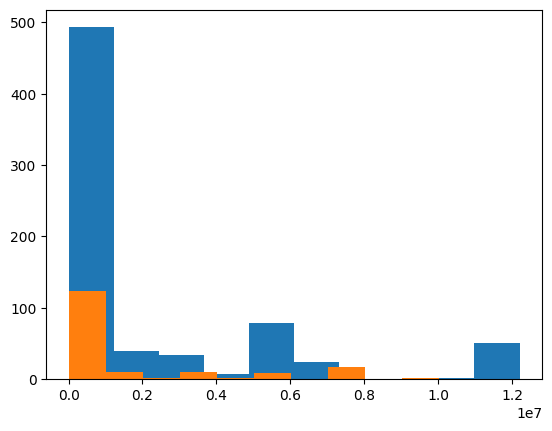

In [263]:
print(len(Barea))
plt.hist(Barea)
plt.hist(Marea)

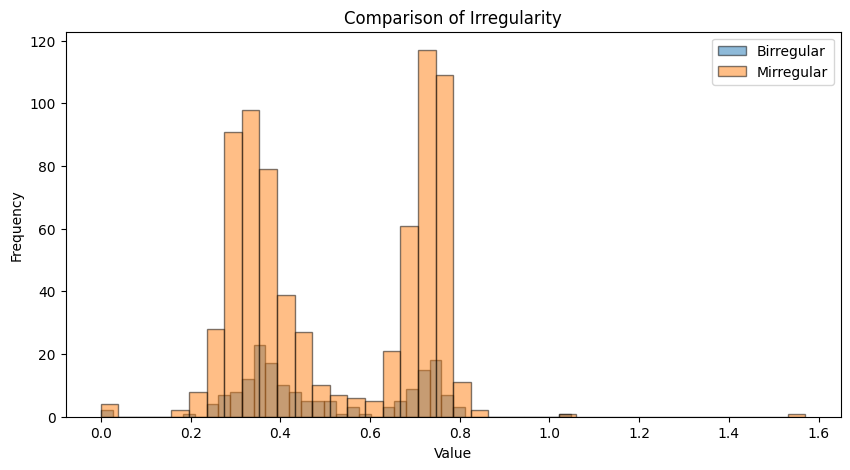

In [264]:
plt.figure(figsize=(10, 5))

# Plot histograms for Barea and Marea in the same plot
plt.hist(Mirregular, bins=40, edgecolor='black', alpha=0.5, label='Birregular')
plt.hist(Birregular, bins=40, edgecolor='black', alpha=0.5, label='Mirregular')

# Adding titles and labels
plt.title('Comparison of Irregularity')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Adding a legend to differentiate the datasets
plt.legend(loc='upper right')

plt.show()

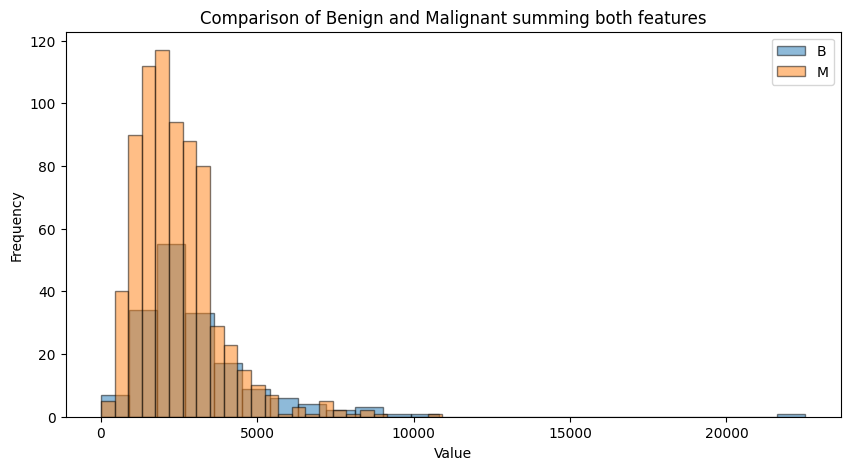

In [254]:
B_compare= Birregular + Barea
M_compare= Mirregular + Marea

plt.figure(figsize=(10, 5))

# Plot histograms for Barea and Marea in the same plot
plt.hist(Mirregular, bins=25, edgecolor='black', alpha=0.5, label='B')
plt.hist(Birregular, bins=25, edgecolor='black', alpha=0.5, label='M')

# Adding titles and labels
plt.title('Comparison of Benign and Malignant summing both features')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Adding a legend to differentiate the datasets
plt.legend(loc='upper right')

plt.show()

In [255]:
def estimate_success_rate(malignant_pred, filename, diagnosis):
    success_rate=0
    malignant = np.where(diagnosis == "malignant")[0]
    malignant_image_names = filename[malignant]
    #print(malignant_image_names)
    set_malignant_pred =set()
    set_malignant_data =set()
    for i in range(len(malignant_pred)):
        set_malignant_pred.add(malignant_pred[i][0])
    for i in range(len(malignant_image_names)):
        set_malignant_data.add(malignant_image_names[i][0])

    print("pred",set_malignant_pred)
    print("data",set_malignant_data)

    success=  set_malignant_pred.intersection(set_malignant_data)
    print(success)
    success_rate= len(success)
    return success_rate/len(malignant)

In [256]:
def estimate_success_rateM(malignant_pred, filename, diagnosis):
    success_rate=0
    malignant = np.where(diagnosis == "malignant")[0]
    malignant_image_names = filename[malignant]
    #print(malignant_image_names)
    set_malignant_pred =set()
    set_malignant_data =set()
    for i in range(len(malignant_pred)):
        set_malignant_pred.add(malignant_pred[i][0])
    for i in range(len(malignant_image_names)):
        set_malignant_data.add(malignant_image_names[i][0])

    print("pred",set_malignant_pred)
    print("data",set_malignant_data)

    success=  set_malignant_pred.intersection(set_malignant_data)
    print(success)

    false_predictions = len(set_malignant_pred) - len(success)
    if len(success) + false_predictions!= 0:
        success_rate = len(success) / (len(success) + false_predictions)
    else: 
        success_rate=0
    return success_rate, len(success),len(malignant)

In [257]:
def estimate_success_rateF1(malignant_pred, filename, diagnosis):
    success_rate=0
    malignant = np.where(diagnosis == "malignant")[0]
    malignant_image_names = filename[malignant]
    #print(malignant_image_names)
    set_malignant_pred =set()
    set_malignant_data =set()
    for i in range(len(malignant_pred)):
        set_malignant_pred.add(malignant_pred[i][0])
    for i in range(len(malignant_image_names)):
        set_malignant_data.add(malignant_image_names[i][0])

    print("pred",set_malignant_pred)
    print("data",set_malignant_data)

    success=  set_malignant_pred.intersection(set_malignant_data)
    
    #false_positives = len(malignant_pred) - len(malignant)
    true_positives = len(success)

    if len(malignant_pred) > 0:
        precision = true_positives / len(malignant_pred)
    else:
        precision = 0

    # Recall: How many relevant items are selected?
    if len(set_malignant_data) > 0:
        recall = true_positives / len(malignant)
    else:
        recall = 0

    # F1 Score: Harmonic mean of precision and recall
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0

    return f1_score, len(set_malignant_pred), len(set_malignant_data)


### It seems none of the features can be used solely the diagnose the type of lesion as their success rate is rather low

Something went wrong
Something went wrong
Something went wrong
Something went wrong
Something went wrong
Something went wrong
900
Malignant images: 465
Benign images: 435


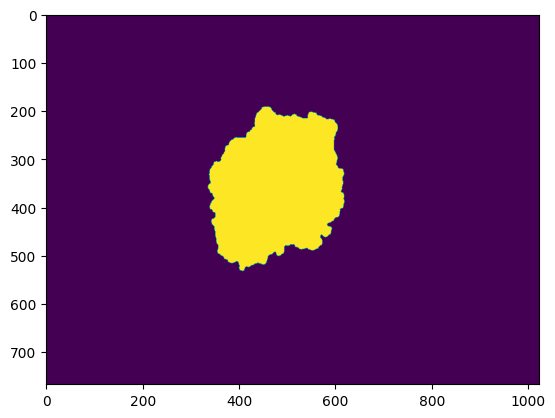

In [265]:
#features:'angles','sum_std_deviation_vecs_lengths','sum_std_angles','perimeter'
def analyze_images(images_path, feature, threshold):
    loaded_images = []
    irregularity_images = []
    areas_images = []
    areas_imagesN = []
    malignant_images = []
    benign_images = []
    #threshhold = 0.5 
    
    for image_name in os.listdir(images_path):
        if image_name.endswith(".png"):
            img = Image.open(os.path.join(images_path, image_name))
            irregularity_value = irregularity(img,feature)
            irregularity_images.append(irregularity_value)
            area_value = try_areas(img)
            areas_images.append(area_value)
            area_valueN = try_areas(img)
            areas_imagesN.append(area_valueN)
            image_name= image_name[:12]
            if irregularity_value>= threshold:
                malignant_images.append((image_name, irregularity_value))
            if irregularity_value< threshold and irregularity!=0:
                benign_images.append((image_name, irregularity_value))
            loaded_images.append(img)
            
    plt.imshow(loaded_images[4])
    print(len(loaded_images))

    return malignant_images, benign_images, irregularity_images

# Example usage:
images_path = "C:/Users/35196/OneDrive - Universidade de Lisboa/Documentos/Master/Data Science/skin/ISBI2016_ISIC_Part3B_Training_Data"
feature = 'angles'
threshold = 0.43
malignant_images, benign_images,irregularity_images = analyze_images(images_path, feature, threshold)

print("Malignant images:", len(malignant_images))
print("Benign images:", len(benign_images))

In [266]:
success_rate,Npred_malignant, Nmalignant = estimate_success_rateM(malignant_images, filename_as_np, diagnosis_as_np)
print(success_rate)

pred {'ISIC_0000543', 'ISIC_0009966', 'ISIC_0000369', 'ISIC_0010330', 'ISIC_0000016', 'ISIC_0010066', 'ISIC_0010236', 'ISIC_0000353', 'ISIC_0000044', 'ISIC_0000252', 'ISIC_0010475', 'ISIC_0011323', 'ISIC_0000496', 'ISIC_0008236', 'ISIC_0010003', 'ISIC_0000009', 'ISIC_0011229', 'ISIC_0000034', 'ISIC_0000488', 'ISIC_0010252', 'ISIC_0000300', 'ISIC_0001449', 'ISIC_0001742', 'ISIC_0010438', 'ISIC_0011157', 'ISIC_0000079', 'ISIC_0010170', 'ISIC_0000225', 'ISIC_0010491', 'ISIC_0000046', 'ISIC_0000511', 'ISIC_0000179', 'ISIC_0011358', 'ISIC_0002438', 'ISIC_0010462', 'ISIC_0000017', 'ISIC_0009995', 'ISIC_0000054', 'ISIC_0011079', 'ISIC_0011130', 'ISIC_0010220', 'ISIC_0000307', 'ISIC_0010185', 'ISIC_0000364', 'ISIC_0010247', 'ISIC_0010071', 'ISIC_0000285', 'ISIC_0010364', 'ISIC_0000048', 'ISIC_0000021', 'ISIC_0002488', 'ISIC_0001102', 'ISIC_0010087', 'ISIC_0010240', 'ISIC_0011208', 'ISIC_0000105', 'ISIC_0011120', 'ISIC_0010244', 'ISIC_0011123', 'ISIC_0011225', 'ISIC_0000203', 'ISIC_0010069', 'I

In [267]:
success_rate,Npred_malignant, Nmalignant = estimate_success_rateF1(malignant_images, filename_as_np, diagnosis_as_np)
print(success_rate)

pred {'ISIC_0000543', 'ISIC_0009966', 'ISIC_0000369', 'ISIC_0010330', 'ISIC_0000016', 'ISIC_0010066', 'ISIC_0010236', 'ISIC_0000353', 'ISIC_0000044', 'ISIC_0000252', 'ISIC_0010475', 'ISIC_0011323', 'ISIC_0000496', 'ISIC_0008236', 'ISIC_0010003', 'ISIC_0000009', 'ISIC_0011229', 'ISIC_0000034', 'ISIC_0000488', 'ISIC_0010252', 'ISIC_0000300', 'ISIC_0001449', 'ISIC_0001742', 'ISIC_0010438', 'ISIC_0011157', 'ISIC_0000079', 'ISIC_0010170', 'ISIC_0000225', 'ISIC_0010491', 'ISIC_0000046', 'ISIC_0000511', 'ISIC_0000179', 'ISIC_0011358', 'ISIC_0002438', 'ISIC_0010462', 'ISIC_0000017', 'ISIC_0009995', 'ISIC_0000054', 'ISIC_0011079', 'ISIC_0011130', 'ISIC_0010220', 'ISIC_0000307', 'ISIC_0010185', 'ISIC_0000364', 'ISIC_0010247', 'ISIC_0010071', 'ISIC_0000285', 'ISIC_0010364', 'ISIC_0000048', 'ISIC_0000021', 'ISIC_0002488', 'ISIC_0001102', 'ISIC_0010087', 'ISIC_0010240', 'ISIC_0011208', 'ISIC_0000105', 'ISIC_0011120', 'ISIC_0010244', 'ISIC_0011123', 'ISIC_0011225', 'ISIC_0000203', 'ISIC_0010069', 'I

In [268]:
print(Npred_malignant, Nmalignant)

465 173


In [269]:
irregular, regular =check_irregularities(irregularity_images, threshold)

print(len(irregular[0]),len(regular[0]))

print(irregular[0])

465 435
[  0   1   2   4   5   6   7   8   9  10  11  12  14  16  18  19  23  24
  25  26  27  29  30  31  32  33  36  37  38  42  43  45  46  47  48  49
  50  52  53  54  55  56  57  58  59  60  62  66  71  72  73  79  80  84
  86  88  91  92  97 103 104 105 112 113 118 119 124 128 132 133 136 137
 144 147 148 150 151 152 154 156 160 161 162 165 168 169 170 172 173 174
 175 177 179 182 185 188 189 190 193 195 197 198 200 202 210 214 218 220
 222 223 225 227 231 236 238 240 242 245 251 252 253 254 260 262 263 264
 266 268 269 270 273 274 275 280 282 285 286 287 288 290 291 293 294 296
 297 299 302 303 305 306 307 308 309 310 311 312 313 314 317 319 321 322
 324 325 326 327 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 346 347 348 349 351 352 355 356 360 363 364 365 366 367 373 376 378
 380 381 382 384 385 387 390 391 392 397 398 399 400 402 403 404 405 407
 409 413 414 415 417 420 427 429 437 443 447 453 454 455 456 462 463 464
 466 471 473 477 478 479 484 488 489 490 49